<a href="https://colab.research.google.com/github/It21258794/DL_Assignment_SE4050/blob/main/ANN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


In [ ]:
# Load dataset
df = pd.read_csv('flights_sample_3m.csv')
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Feature engineering: Extract hour from scheduled departure time
df['Hour'] = df['CRS_DEP_TIME'].astype(str).str.zfill(4).str[:2].astype(int)

# Select features
features = df[['Hour', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
               'CRS_ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME',
               'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE']]

# Create target variables
dep_delay_class = np.where(df['DEP_DELAY'] > 15, 1, 0)
arr_delay_class = np.where(df['ARR_DELAY'] > 15, 1, 0)
cancel_class = df['CANCELLED'].astype(int)

# Preprocessing: Numeric columns
numeric_features = features.columns.tolist()

# Preprocessing pipeline for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)]
)

# Split data into training and testing sets
X_train, X_test, y_train_dep, y_test_dep = train_test_split(features, dep_delay_class, test_size=0.2, random_state=42)
_, _, y_train_arr, y_test_arr = train_test_split(features, arr_delay_class, test_size=0.2, random_state=42)
_, _, y_train_cancel, y_test_cancel = train_test_split(features, cancel_class, test_size=0.2, random_state=42)

# Preprocess training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Reshape the target arrays
y_train_dep = y_train_dep.reshape(-1, 1)
y_train_arr = y_train_arr.reshape(-1, 1)
y_train_cancel = y_train_cancel.to_numpy().reshape(-1, 1)

y_test_dep = y_test_dep.reshape(-1, 1)
y_test_arr = y_test_arr.reshape(-1, 1)
y_test_cancel = y_test_cancel.to_numpy().reshape(-1, 1)

# Compute class weights to handle imbalance for each target
class_weights_dep = compute_class_weight('balanced', classes=np.unique(y_train_dep.ravel()), y=y_train_dep.ravel())
class_weights_arr = compute_class_weight('balanced', classes=np.unique(y_train_arr.ravel()), y=y_train_arr.ravel())
class_weights_cancel = compute_class_weight('balanced', classes=np.unique(y_train_cancel.ravel()), y=y_train_cancel.ravel())

class_weight_dict_dep = dict(enumerate(class_weights_dep))
class_weight_dict_arr = dict(enumerate(class_weights_arr))
class_weight_dict_cancel = dict(enumerate(class_weights_cancel))

# Build multi-output ANN model with three separate outputs
input_layer = Input(shape=(X_train_processed.shape[1],))

# Shared layers
x = Dense(512, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Output for departure delay
output_dep = Dense(1, activation='sigmoid', name='dep_delay')(x)

# Output for arrival delay
output_arr = Dense(1, activation='sigmoid', name='arr_delay')(x)

# Output for cancellation
output_cancel = Dense(1, activation='sigmoid', name='cancel')(x)

# Create model
model = Model(inputs=input_layer, outputs=[output_dep, output_arr, output_cancel])

# Compile the model with multiple losses for the three outputs
model.compile(optimizer='adam',
              loss={
                  'dep_delay': 'binary_crossentropy',
                  'arr_delay': 'binary_crossentropy',
                  'cancel': 'binary_crossentropy'
              },
              metrics={
                  'dep_delay': ['accuracy'],
                  'arr_delay': ['accuracy'],
                  'cancel': ['accuracy']
              })

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model with multiple outputs
history = model.fit(X_train_processed, [y_train_dep, y_train_arr, y_train_cancel],
                    epochs=20, batch_size=512, validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - arr_delay_accuracy: 0.9832 - cancel_accuracy: 0.9929 - dep_delay_accuracy: 0.9717 - loss: 0.1446 - val_arr_delay_accuracy: 0.9984 - val_cancel_accuracy: 0.9998 - val_dep_delay_accuracy: 0.9963 - val_loss: 0.0202
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - arr_delay_accuracy: 0.9982 - cancel_accuracy: 0.9998 - dep_delay_accuracy: 0.9940 - loss: 0.0233 - val_arr_delay_accuracy: 0.9994 - val_cancel_accuracy: 0.9999 - val_dep_delay_accuracy: 0.9948 - val_loss: 0.0157
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - arr_delay_accuracy: 0.9988 - cancel_accuracy: 0.9998 - dep_delay_accuracy: 0.9950 - loss: 0.0172 - val_arr_delay_accuracy: 0.9993 - val_cancel_accuracy: 0.9999 - val_dep_delay_accuracy: 0.9967 - val_loss: 0.0104
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - arr_delay_accuracy: 0.9990 - cancel_accuracy: 0.9998 - dep_delay_accuracy: 0.9956 - loss: 0.0150 - val_arr_delay_accuracy: 0.9989 - val_

In [ ]:
# Evaluate the model on the test set
results = model.evaluate(X_test_processed, [y_test_dep, y_test_arr, y_test_cancel])

# Unpack based on the actual output structure
loss_total, acc_dep, acc_arr, acc_cancel = results

# Print results
print(f'Total Loss: {loss_total:.4f}')
print(f'Departure Delay Accuracy: {acc_dep:.4f}')
print(f'Arrival Delay Accuracy: {acc_arr:.4f}')
print(f'Cancellation Accuracy: {acc_cancel:.4f}')


18750/18750 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - arr_delay_accuracy: 1.0000 - cancel_accuracy: 0.9999 - dep_delay_accuracy: 0.9989 - loss: 0.0048
Total Loss: 0.0047
Departure Delay Accuracy: 1.0000
Arrival Delay Accuracy: 0.9999
Cancellation Accuracy: 0.9990


In [ ]:
# Predict results
y_pred = model.predict(X_test_processed)

# Extract predictions for each target
y_pred_dep = y_pred[0]  # First output for departure delay
y_pred_arr = y_pred[1]  # Second output for arrival delay
y_pred_cancel = y_pred[2]  # Third output for cancellation

# Convert probabilities to binary classification (0 or 1)
y_pred_dep_classes = (y_pred_dep > 0.5).astype(int)
y_pred_arr_classes = (y_pred_arr > 0.5).astype(int)
y_pred_cancel_classes = (y_pred_cancel > 0.5).astype(int)

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step


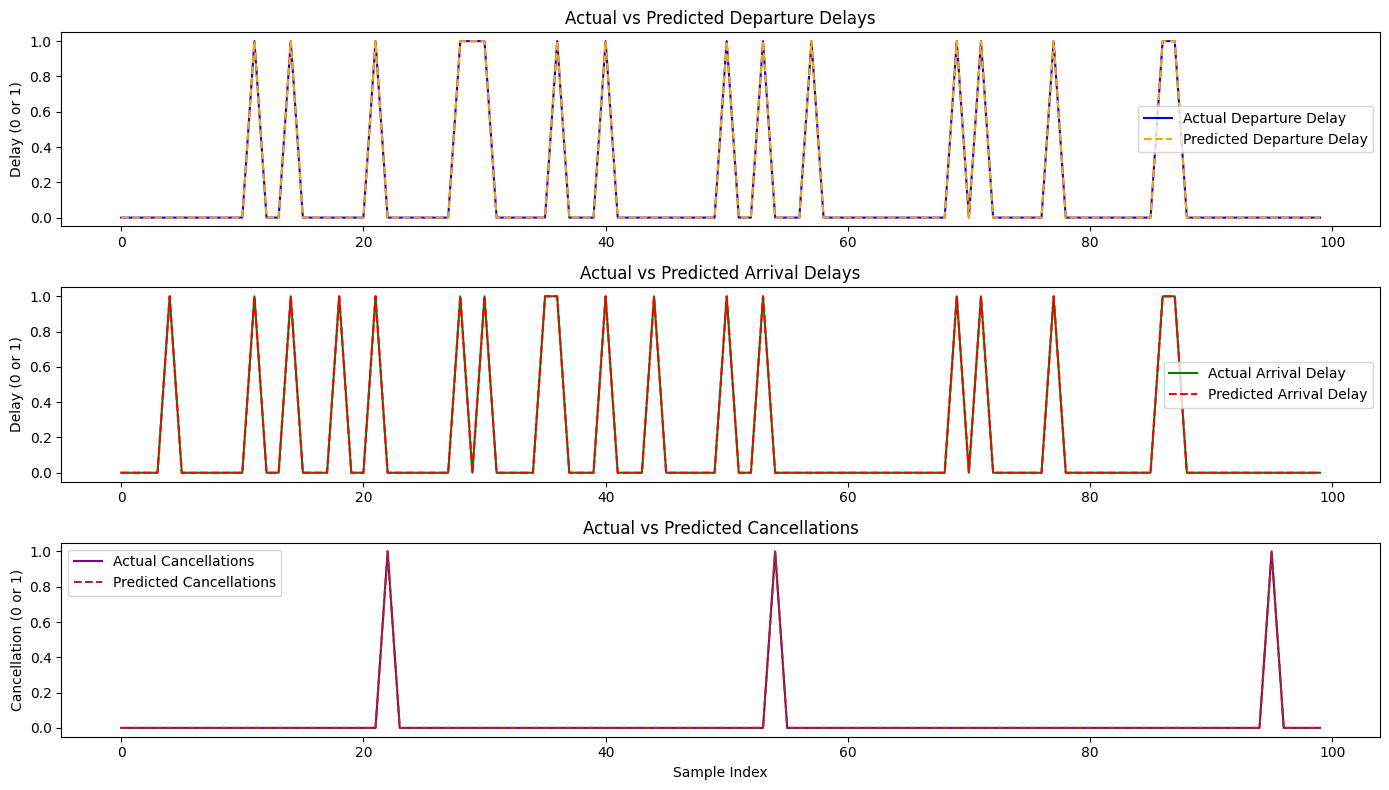

In [ ]:
# Plot predictions vs actual values (for the first 100 test samples)
plt.figure(figsize=(14, 8))

# Plot for departure delay
plt.subplot(3, 1, 1)
plt.plot(y_test_dep[:100], label='Actual Departure Delay', color='blue')
plt.plot(y_pred_dep_classes[:100], label='Predicted Departure Delay', color='orange', linestyle='--')
plt.title('Actual vs Predicted Departure Delays')
plt.ylabel('Delay (0 or 1)')
plt.legend()

# Plot for arrival delay
plt.subplot(3, 1, 2)
plt.plot(y_test_arr[:100], label='Actual Arrival Delay', color='green')
plt.plot(y_pred_arr_classes[:100], label='Predicted Arrival Delay', color='red', linestyle='--')
plt.title('Actual vs Predicted Arrival Delays')
plt.ylabel('Delay (0 or 1)')
plt.legend()

# Plot for cancellations
plt.subplot(3, 1, 3)
plt.plot(y_test_cancel[:100], label='Actual Cancellations', color='purple')
plt.plot(y_pred_cancel_classes[:100], label='Predicted Cancellations', color='brown', linestyle='--')
plt.title('Actual vs Predicted Cancellations')
plt.ylabel('Cancellation (0 or 1)')
plt.xlabel('Sample Index')
plt.legend()

plt.tight_layout()
plt.show()